In [319]:
%matplotlib inline
%env PYTORCH_ENABLE_MPS_FALLBACK=1

import os
import numpy as np
import pandas as pd
import torch
from torch import nn # torch.nn contains all of PT building blocks for Neural Networks
import torchmetrics
import matplotlib.pyplot as plt
import sklearn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor


DEVICE = "cuda" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_available() \
    else "cpu"

RANDOM_SEED = 42

torch.set_default_device(DEVICE)
torch.manual_seed(RANDOM_SEED)
print(f"Seed: {RANDOM_SEED}", f"Device: {DEVICE}", f"PyTorch: {torch.__version__}", f"TorchVision: {torchvision.__version__}")

env: PYTORCH_ENABLE_MPS_FALLBACK=1
Seed: 42 Device: mps PyTorch: 2.0.1 TorchVision: 0.15.2


# PyTorch Computer Vision

## Computer vision libraries in PyTorch

0. `torchvision` ->
1. `torchvision.datasets` -> get datasets and dat loading functions for CV
2. `torchvision.models` -> pretrained CV models
3. `torchvision.transforms` -> functions to manipulate vision data
4. `torch.utils.data.Dataset` -> base dataset class for PyTorch
5. `torch.utils.data.DataLoader` ->  create a Python iterable over a dataset
6. `torchserve` -> serving pt models
7. `torchdata` -> advanced data pipelines
8. possibility to work with torch on XLA

## Getting a dataset

1. Fashion MNIST
2. ImageNet (millions of images) 

In [320]:
train_data = datasets.FashionMNIST(
    root= "data", # save data to ...
    train =  True, # do we want the training dataset?
    download = True, # enable download 
    transform=torchvision.transforms.ToTensor(), # how do we want to transform data?
    target_transform=None # how do we want to transform labels?
)

test_data = datasets.FashionMNIST(
    root= "data", # save data to ...
    train =  False, # we want the test dataset
    download = True, # enable download 
    transform=torchvision.transforms.ToTensor(), # how do we want to transform data?
    target_transform=None # how do we want to transform labels?
)

train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [321]:
image, label = train_data[0]

image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [322]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [323]:
class_names_to_idx = train_data.class_to_idx
class_names_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [324]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [325]:
# Check the shape of our image
image.shape, class_names[label] # Grayscale, so only one color channel

(torch.Size([1, 28, 28]), 'Ankle boot')

## Visualizing image data

In [326]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape")

Image shape


Text(0.5, 1.0, 'Ankle boot')

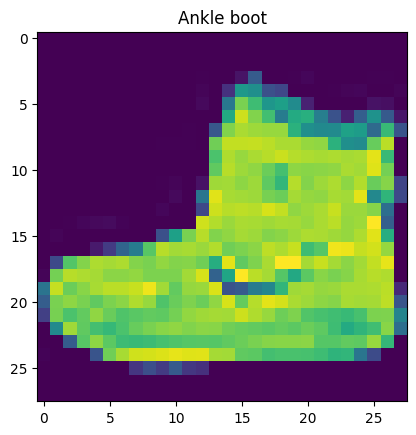

In [327]:
plt.imshow(image.squeeze()) # get rid of extra first 
plt.title(class_names[label])

(-0.5, 27.5, 27.5, -0.5)

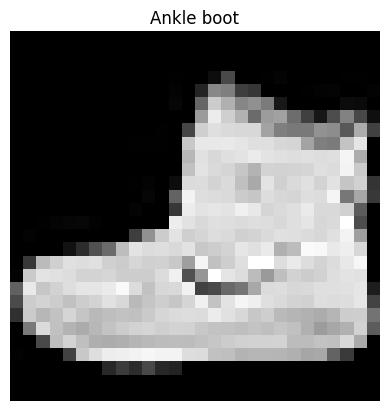

In [328]:
plt.imshow(image.squeeze(), cmap="gray") # get rid of extra first 
plt.title(class_names[label])
plt.axis(False)

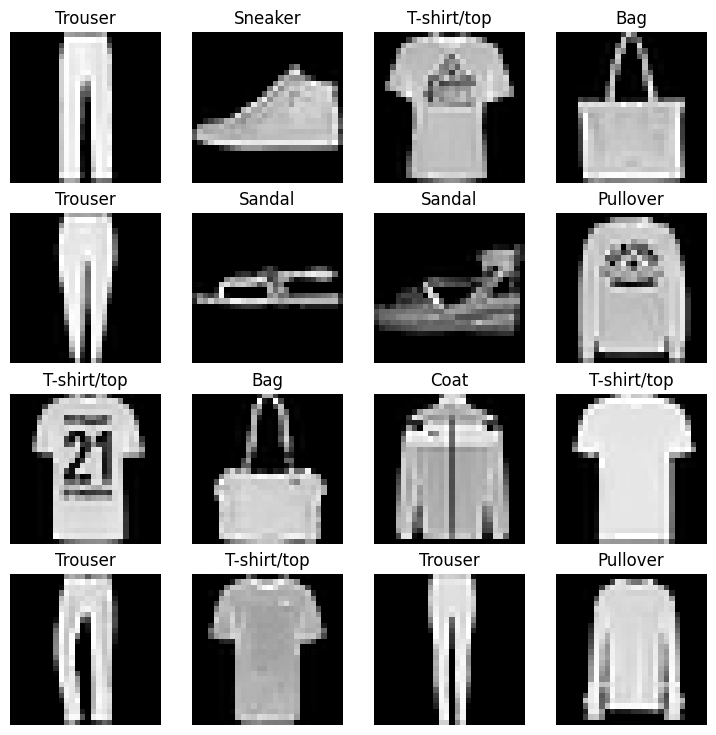

In [329]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
random_idxs = []

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)


## Preparing DataLoaders 

Right now, our data is in the form of PyTorch Datasets

DataLoader turns our dataset into a Python iterable. 

More specifically, we want to turn our data into batches (or mini-batches). Why would we do this?

1. More computationally efficient: our computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we breat it down to 32 images at a time (batch size of 32)
2. It gives our nn more chances to update its gradients per epoch (complete pass across all training data)

Search "Mini-batch Gradient Descent" for more info.

In [330]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [331]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2c1e24890>,
 <torch.utils.data.dataloader.DataLoader at 0x309879e90>)

In [332]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [333]:
# Check out what's inside the training DataLoader
torch.set_default_device('cpu')

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch = train_features_batch.to(DEVICE)
train_labels_batch = train_labels_batch.to(DEVICE)

train_features_batch.device, train_labels_batch.device, train_features_batch.shape, train_labels_batch.shape                                            

(device(type='mps', index=0),
 device(type='mps', index=0),
 torch.Size([32, 1, 28, 28]),
 torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

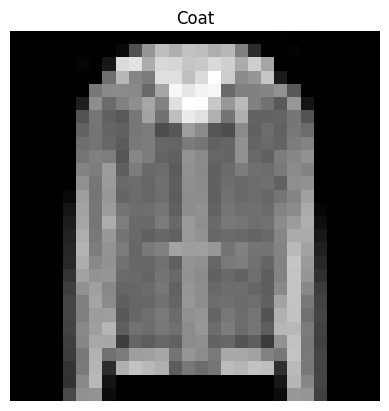

In [334]:
# Visualize a random sample from the batch

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()

img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.cpu().squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

## Baseline models for CV

When building a series of machine learning modelling experiments it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In [335]:
# Create a flatten layer

flatten_model = nn.Flatten()

# Get a single sample

x = train_features_batch[0]

output = flatten_model(x)
# Before: [color channels, height, width]
# After: [color channels, height * width]
print(x.shape, '->', output.shape) # 
output.squeeze()

torch.Size([1, 28, 28]) -> torch.Size([1, 784])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
        0.0510, 0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0039, 0.0039, 0.0000, 

In [336]:
class FashionMNISTModelV0(nn.Module):
    def __init__(
        self, 
        input_shape: int,
        hidden_units: int,
        output_shape: int
    ):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [337]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [338]:
dummy_x = torch.rand([1, 1, 28, 28]) # batch of one with one color channel
model_0(dummy_x).shape

torch.Size([1, 10])

In [339]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### Setup loss, optim and eval metrics

* Loss -> multi-class so `nn.CrossEntropyLoss()`
* Optimizer -> simple SGD `torch.optim.SGD()`
* Evaluation metric -> accuracy

In [340]:
from torchmetrics.classification import MulticlassAccuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

## Creating a training loop and training a model on batches of data

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*
4. Print out what's happening
5. Time it with `%timeit`

In [341]:
%timeit

from tqdm.auto import tqdm
from torchmetrics.classification import MulticlassAccuracy

torch.manual_seed(42)

EPOCHS = 3
BATCHES = 2
LOG_INTERVAL = 400

model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n")
    ### Training
    train_loss = 0
    
    # Add a loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss # Accumulate training loss for each batch
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step() # We update once per batch, instead of per epoch

        # Log
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0
    
    model_0.eval()

    accuracy_fn = MulticlassAccuracy(num_classes=len(class_names))
    
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)

            test_loss += loss_fn(test_pred, y_test)

            test_acc += accuracy_fn(test_pred.argmax(dim=1), y_test)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.5886 | Test loss: 0.5544 | Test acc: 0.7933
Epoch: 1

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4743 | Test loss: 0.5186 | Test acc: 0.8101
Epoch: 2

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4530 | Test loss: 0.5032 | Test acc: 0.8149


In [342]:
torch.manual_seed(42)

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
    train_loss = 0
    model = model.to(DEVICE)
    # Add a loop through the training batches (60000 // 32 = 1875)
    for X, y in tqdm(data_loader, desc="Training"):
        X, y = X.to(DEVICE), y.to(DEVICE)
        
        model.train()

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss # Accumulate training loss for each batch
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step() # We update once per batch, instead of per epoch

    # Divide total train loss by length of train dataloader
    train_loss /= len(data_loader)

    print(f"Train loss: {train_loss:.4f}")
    
    return {
        "model_name": model.__class__.__name__,
        "model_loss": train_loss.item()
    }

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    
    test_loss, test_acc = 0, 0
    model = model.to(DEVICE)
    model.eval()
    
    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc="Testing"):
            X, y = X.to(DEVICE), y.to(DEVICE)
            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)

            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    return {
        "model_name": model.__class__.__name__,
        "model_loss": test_loss.item(),
        "model_acc": test_acc
    }

model_0_results = test_step(model=model_0.to(DEVICE),
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn.to(DEVICE))

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.5032 | Test acc: 0.8149


In [343]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)
        

In [344]:
#%%timeit

from tqdm.auto import tqdm
from torchmetrics.classification import MulticlassAccuracy

torch.manual_seed(42)

EPOCHS = 3

model_1 = FashionMNISTModelV1(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

for epoch in tqdm(range(EPOCHS), desc='Epochs'):
    print(f"\n\n--- Epoch {epoch} ---")
    ### Training    
    train_step(model_1, train_dataloader, loss_fn)
    
    ### Testing
    test_step(model_1, test_dataloader, loss_fn, accuracy_fn.to(DEVICE))

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]



--- Epoch 0 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.6288


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.5412 | Test acc: 0.8002


--- Epoch 1 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.4727


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.4999 | Test acc: 0.8153


--- Epoch 2 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.4415


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.4894 | Test acc: 0.8184


## Convolutional Neural Networks with PyTorch

1. Input Layer -> [b, c, w. h] takes target images and preprocesses them for further layers
2. Convolution Layer -> Extracts/learns the most important features from target images -> Multiple, can create with `torch.nn.ConvXd()`
3. Hidden activation / Non-linear activation -> Adds non-linearity to learned features (non-straight lines) -> usually `ReLU`
4. Pooling layer -> Reduces the dimensionality of learned image features -> `torch.nn.MaxPool2d` or `torch.nn.AvgPool2d`
5. Output layer / Linear Layer -> Takes learned features and outputs them in the shape of target labels -> `torch.nn.Linear(out_features=number_of_classes)`
6. Output activation -> converts output logits to prediction probabilities -> `torch.sigmoid` for binary classif and `torch.softmax` for multi-class

In [345]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website.
    """
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int,
                 sample_batch: torch.Tensor):
        
        super().__init__()
        self.sample_batch = sample_batch
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        shape_multiplier = self.compute_shape_multiplier()
            
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * shape_multiplier,
                      out_features=output_shape)
        )

    def compute_shape_multiplier(self):
        x, y = self.sample_batch

        with torch.inference_mode():
            x = self.block_1(x)
            x = self.block_2(x)
            return x.size(2) * x.size(3)
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names), 
                              sample_batch=next(iter(train_dataloader)))
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [346]:
torch.manual_seed(42)

EPOCHS = 3


model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=32,
                              output_shape=len(class_names), 
                              sample_batch=next(iter(train_dataloader)))

model_2 = model_2.to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

for epoch in tqdm(range(EPOCHS), desc='Epochs'):
    print(f"\n\n--- Epoch {epoch} ---")
    ### Training    
    train_step(model_2.to(DEVICE), train_dataloader, loss_fn)
    
    ### Testing
    test_step(model_2, test_dataloader, loss_fn, accuracy_fn.to(DEVICE))

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]



--- Epoch 0 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.5787


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.3587 | Test acc: 0.8657


--- Epoch 1 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.3105


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.3170 | Test acc: 0.8782


--- Epoch 2 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.2688


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.2933 | Test acc: 0.8870


--- Epoch 3 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.2454


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.2803 | Test acc: 0.8900


--- Epoch 4 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.2285


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.2711 | Test acc: 0.8928


--- Epoch 5 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.2147


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.2775 | Test acc: 0.8937


--- Epoch 6 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.2036


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.2733 | Test acc: 0.8988


--- Epoch 7 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.1932


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.2679 | Test acc: 0.9006


--- Epoch 8 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.1845


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.2736 | Test acc: 0.8971


--- Epoch 9 ---


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.1769


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.2730 | Test acc: 0.9019
